In [28]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

In [29]:
def compute_jacobian_norm_batched(unet, latents, t, prompt_embeds, num_projections=4):
    """
    Batched Hutchinson estimator for ||J||_F.
    Returns a tensor of shape (batch_size,) containing the Jacobian norm for each sample.
    """
    prompt_embeds = prompt_embeds.detach()
    latents = latents.detach()
    
    batch_size = latents.shape[0]
    
    with torch.enable_grad():
        prompt_embeds.requires_grad_(True)
        # Forward pass
        noise_pred = unet(latents, t, encoder_hidden_states=prompt_embeds).sample
        
        sq_norm_sum = torch.zeros(batch_size, device=latents.device)
        
        for k in range(num_projections):
            # Random probe v
            v = torch.randn_like(noise_pred)
            
            v_dot_eps_sum = torch.sum(noise_pred * v)
            
            retain = (k < num_projections - 1)
            grads = torch.autograd.grad(v_dot_eps_sum, prompt_embeds, retain_graph=retain, create_graph=False)[0]
            
            # Squared norm per sample
            grads_sq_flat = grads.view(batch_size, -1).pow(2)
            sample_sq_norms = grads_sq_flat.sum(dim=1) # [B]
            
            sq_norm_sum += sample_sq_norms.detach()
            
        est_frob_sq = sq_norm_sum / max(1, float(num_projections))
        return est_frob_sq.sqrt() # [B]


Loading model...
Loading prompts...
Generating conditional images (Task 4)...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generating unconditionally and calculating Jacobian (Task 5)...


Uncond Trajectory: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]


Regenerating from max Jacobian point (Task 7)...
Prompt 0: Max Norm at Step 12 (Val: 57.5065)
Prompt 1: Max Norm at Step 7 (Val: 239.2850)


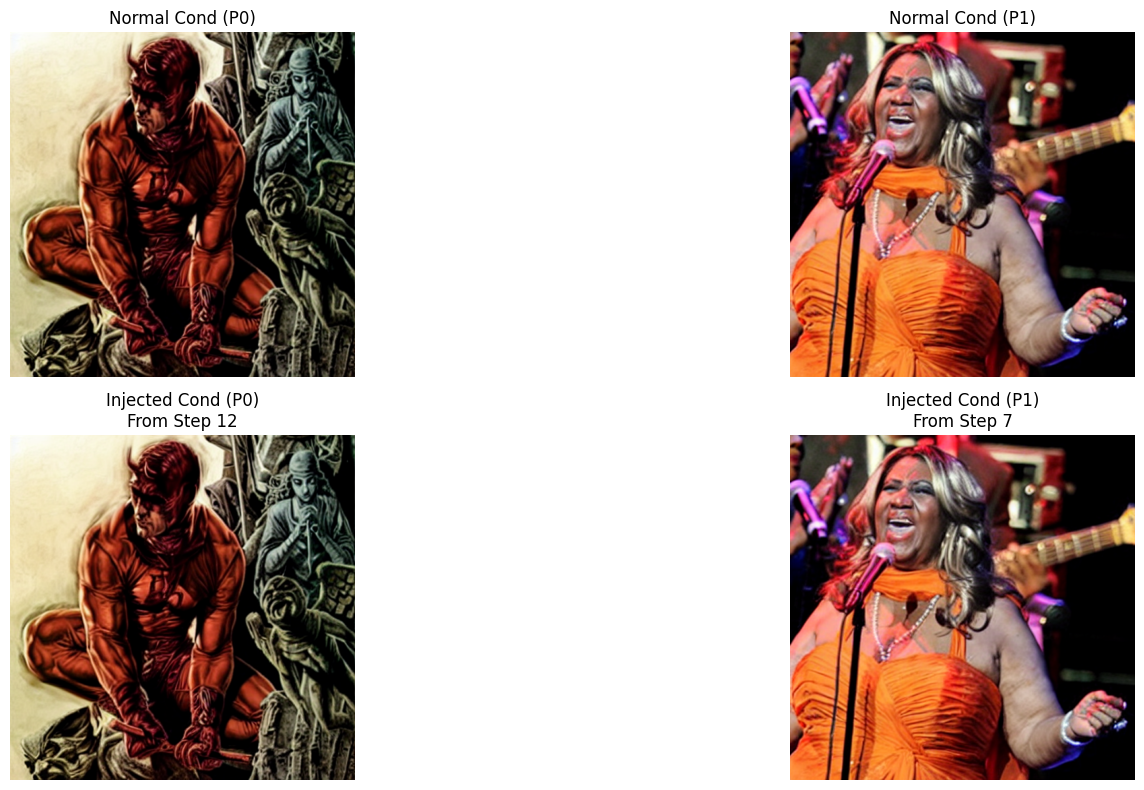

In [33]:
# Configuration
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"
save_dir = "results/jacobian_test"
os.makedirs(save_dir, exist_ok=True)
num_samples = 2
start_idx = 10
end_idx = start_idx + num_samples

# 1. Load Model
print("Loading model...")
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32).to(device)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# 2. Load Prompts
print("Loading prompts...")
with open("prompts/sd1_mem.txt", "r") as f:
    prompts = [line.strip() for line in f.readlines()][start_idx:end_idx]

# Settings
num_inference_steps = 50
guidance_scale = 7.5
generator_seed = torch.Generator(device).manual_seed(42)

# 4. Generate Images (Conditional)
print("Generating conditional images (Task 4)...")
cond_images = []
for prompt in prompts:
    image = pipeline(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=torch.Generator(device).manual_seed(42)).images[0]
    cond_images.append(image)

# 5. Unconditional Generation + Jacobian
print("Generating unconditionally and calculating Jacobian (Task 5)...")
pipeline.scheduler.set_timesteps(num_inference_steps)
timesteps = pipeline.scheduler.timesteps

uncond_input = pipeline.tokenizer([""], padding="max_length", max_length=pipeline.tokenizer.model_max_length, truncation=True, return_tensors="pt")
uncond_embeddings = pipeline.text_encoder(uncond_input.input_ids.to(device))[0]

latents = torch.randn((1, pipeline.unet.config.in_channels, 64, 64), generator=torch.Generator(device).manual_seed(42), device=device, dtype=torch.float32)

target_prompt_embeds = []
for prompt in prompts:
    text_input = pipeline.tokenizer([prompt], padding="max_length", max_length=pipeline.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    temb = pipeline.text_encoder(text_input.input_ids.to(device))[0]
    target_prompt_embeds.append(temb)

jacobian_norms = {i: [] for i in range(len(prompts))}
traj_latents = []

with torch.no_grad():
    for i, t in enumerate(tqdm(timesteps, desc="Uncond Trajectory")):
        traj_latents.append(latents.detach().cpu()) 
        
        # Save generated image at step
        image = pipeline.vae.decode(1 / 0.18215 * latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image_pil = pipeline.image_processor.numpy_to_pil(image.cpu().permute(0, 2, 3, 1).numpy())[0]
        image_pil.save(f"{save_dir}/uncond_step_{i}.png")

        for p_idx, p_emb in enumerate(target_prompt_embeds):
            # Compute Jacobian
            norm = compute_jacobian_norm_batched(pipeline.unet, latents, t, p_emb, num_projections=4)
            jacobian_norms[p_idx].append(norm.item())
        
        noise_pred = pipeline.unet(latents, t, encoder_hidden_states=uncond_embeddings).sample
        latents = pipeline.scheduler.step(noise_pred, t, latents).prev_sample

# Save Jacobian Norms
pd.DataFrame(jacobian_norms).to_csv(f"{save_dir}/jacobian_norms.csv")

# 6 & 7. Find max point and Regenerate
print("Regenerating from max Jacobian point (Task 7)...")
task7_images = []

for p_idx in range(len(prompts)):
    norms = jacobian_norms[p_idx]
    # Find max in first 30 steps
    max_idx = np.argmax(norms[:30])
    target_latent = traj_latents[max_idx+10].to(device)
    
    print(f"Prompt {p_idx}: Max Norm at Step {max_idx} (Val: {norms[max_idx]:.4f})")
    
    curr_latents = target_latent.clone()
    cond_emb = target_prompt_embeds[p_idx]
    
    # Start from t=1 (Index 1)
    for i in range(1, len(timesteps)):
        t = timesteps[i]
        latent_model_input = torch.cat([curr_latents] * 2)
        latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t)
        text_embeddings_input = torch.cat([uncond_embeddings, cond_emb])
        
        with torch.no_grad():
            noise_pred = pipeline.unet(latent_model_input, t, encoder_hidden_states=text_embeddings_input).sample
        
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        curr_latents = pipeline.scheduler.step(noise_pred, t, curr_latents).prev_sample
        
    image = pipeline.vae.decode(1 / 0.18215 * curr_latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image_pil = pipeline.image_processor.numpy_to_pil(image.detach().cpu().permute(0, 2, 3, 1).numpy())[0]
    task7_images.append(image_pil)

# 8. Visualize
fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
for i in range(num_samples):
    axes[0, i].imshow(cond_images[i])
    axes[0, i].set_title(f"Normal Cond (P{i})")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(task7_images[i])
    axes[1, i].set_title(f"Injected Cond (P{i})\nFrom Step {np.argmax(jacobian_norms[i][:30])}")
    axes[1, i].axis("off")
    
plt.tight_layout()
plt.savefig(f"{save_dir}/comparison.png")
plt.show()
